# Building Learning Systems from Scratch: Notes and Mini-Projects

# MIT Maker Portfolio Verification
# This notebook was created by Jazmine Gu
# Original development on Kaggle: https://www.kaggle.com/code/happybookgiggles/simple-systems
# Contact: jgu@raleighcharterhs.org


# Table of Contents:


1. Learning Systems

   1a. Linear Regression- predicting house prices from size

   1b. Logistic regression- predicting email spam

   1c. Small, multi-layer neural network — predicting exam pass/fail
   
2. Probabilistic / statistical models

   2a. Naive Bayes — classifying news topic

   2b. Gaussian Mixture Model — clustering height/weight

   2c. Hidden Markov Model — weather inference

3. Reinforcement Learning

   3a. Q-learning — grid world navigation

   3b. Policy iteration — stochastic portfolio optimization

# 1a. Linear regression — predicting house prices from size

I used linear regression to model the relationship between house size and price. I normalized the x-values to keep numerical stability, and then converted the parameters back to the original units.

**Notes to self:**

**What's the equation?**  
The predicted value for each input is:  
$$
\hat{y}_i = w \cdot x_i + b
$$
where $w$ is the slope and $b$ is the intercept.

**How do we calculate loss, and update the parameters based on loss?**  
Using mean squared error loss:  
$$
L(w, b) = \frac{1}{n} \sum_{i=1}^{n} (\hat{y}_i - y_i)^2
$$
Calculating the gradients of the loss with respect to the parameters to see how changing each parameter affects the error:  
$$
\frac{\partial L}{\partial w} = \frac{2}{n} \sum_{i=1}^{n} (\hat{y}_i - y_i) \cdot x_i
$$
$$
\frac{\partial L}{\partial b} = \frac{2}{n} \sum_{i=1}^{n} (\hat{y}_i - y_i)
$$
Updating the parameters by subtracting the respective gradient multiplied by the learning rate, which reduces the loss:
$$
w := w - \text{lr} \cdot \frac{\partial L}{\partial w}, \quad
b := b - \text{lr} \cdot \frac{\partial L}{\partial b}
$$

**How do I know when to stop updating $w$ and $b$?**  
Since this is a convex function, there is no chance of getting stuck in a local minimum instead of the global minimum. We can stop updating when the change in loss becomes smaller than a very small threshold, or after a maximum number of epochs if the threshold is never reached.


In [5]:
import numpy as np

# DATA: house size (x) vs price (y)
np.random.seed(0)
x = np.random.uniform(500, 3000, 100)  # square feet
true_w, true_b = 150, 20000
y = true_w * x + true_b + np.random.normal(0, 20000, size=len(x))

# Preserve original values
x_raw = x.copy()

# Normalize x
mu = x_raw.mean()
sigma = x_raw.std()
x = (x_raw - mu) / sigma

# MODEL: y_hat = w*x + b
w, b = 0.0, 0.0
lr = 0.01
n = len(x)

# Gradient descent with convergence
tolerance = 1e-6       # stop when improvement in loss is smaller than this
max_epochs = 100000      # prevent infinite loops
prev_loss = float('inf')  # initial previous loss

for epoch in range(max_epochs):
    y_hat = w * x + b
    loss = np.mean((y_hat - y) ** 2)
    
    # Stop if improvement is smaller than tolerance
    if abs(prev_loss - loss) < tolerance:
        print(f"Converged at epoch {epoch}")
        break

    # Compute gradients
    dw = (2/n) * np.sum((y_hat - y) * x)
    db = (2/n) * np.sum(y_hat - y)

    # Gradient descent
    w -= lr * dw
    b -= lr * db

    prev_loss = loss

# Convert parameters back to original units
w_original = w / sigma
b_original = b - (w * mu / sigma)

print("Slope:", w_original)
print("Intercept:", b_original)

Converged at epoch 889
Slope: 149.49547780197474
Intercept: 24695.281071959296


# 1b. Logistic regression — predicting email spam

I used logistic regression to tell if an email is spam or not spam (1 or 0) based on the number of times a keyword appears.

**Notes to self:**

**Why use the sigmoid function?**  
The sigmoid function turns real values into values between 0 and 1, which is good because probabilities must be between 0 and 1.  
The linear combination  
$$
z = w \cdot x + b
$$
represents the log-odds of the outcome. The sigmoid function converts this log-odds value into a probability:  
$$
\hat{y} = \sigma(z) = \frac{1}{1 + e^{-z}}
$$
Mathematically, larger $z$ means higher probabilities and smaller $z$ means lower probabilities, which is great. What's also great is that the sigmoid is continuous and differentiable, which makes it perfect for gradient-based optimization.

**What are $w$ and $b$ for?**  
$w$ is the weight for the feature $x$, which decides how much $x$ affects the probability of spam. A larger $|w|$ means the model is more sensitive to changes in $x$.  
$b$ is intercept, shifting the sigmoid left or right, which comes in handy when $x=0$.

**How is log loss used?**  
The log loss measures how well the predictions match the true labels:  
- If $y = 1$, the loss contribution is $- \log(\hat{y})$  
- If $y = 0$, the loss contribution is $- \log(1 - \hat{y})$  

This penalizes confident but wrong predictions more than less confident ones. The goal is that mean loss over all examples is minimized during training.

**How do I check the model?**  
We have the final $w$ and $b$. For each input $x$ we calculate:  
$$
z = w \cdot x + b, \quad \hat{y} = \sigma(z)
$$
We convert predicted probabilities into labels using a threshold:  
$$
\text{predicted label} =
\begin{cases}
1 & \text{if } \hat{y} \ge 0.5 \\
0 & \text{if } \hat{y} < 0.5
\end{cases}
$$
Finally, we compare predicted labels with the true labels to compute accuracy, which is the fraction of correct predictions.


In [1]:
import numpy as np

# DATA: word frequency vs spam (0/1)
x = np.array([1, 2, 3, 4, 5])  # keyword frequency
y = np.array([0, 0, 0, 1, 1])  # labels: 0 = not spam, 1 = spam

# Normalize feature for numerical stability
x = (x - x.mean()) / x.std()

# Sigmoid function
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

# Initial parameters
w, b = 0.0, 0.0
lr = 0.1

# Gradient descent
for epoch in range(1000):
    z = w * x + b
    y_hat = sigmoid(z)

    # log loss
    loss = -np.mean(y * np.log(y_hat) + (1 - y) * np.log(1 - y_hat))

    # Gradients
    dw = np.mean((y_hat - y) * x)
    db = np.mean(y_hat - y)

    # Update parameters
    w -= lr * dw
    b -= lr * db

# Print final parameters
print("Final weight w:", w)
print("Final bias b:", b)

# Check model; Use model to predict probabilities
z = w * x + b
y_hat = sigmoid(z)

# Convert probabilities to labels
labels = (y_hat >= 0.5).astype(int)

# Calculate accuracy
accuracy = np.mean(labels == y)
print("Accuracy:", accuracy)

# Looking at predictions individually
for xi, yi, phat, pred in zip(x, y, y_hat, labels):
    print(f"x={xi:.2f}, true={yi}, predicted_prob={phat:.2f}, predicted_class={pred}")


Final weight w: 5.137534570500907
Final bias b: -1.6746802995927876
Accuracy: 1.0
x=-1.41, true=0, predicted_prob=0.00, predicted_class=0
x=-0.71, true=0, predicted_prob=0.00, predicted_class=0
x=0.00, true=0, predicted_prob=0.16, predicted_class=0
x=0.71, true=1, predicted_prob=0.88, predicted_class=1
x=1.41, true=1, predicted_prob=1.00, predicted_class=1


# 1c. Small, multi-layer neural network — predicting exam pass/fail

I used a small feedforward neural network with one hidden layer to map input features $x$ to a binary output $y$ (0 or 1) for predicting probabilities.

**Notes to self:**


**What are Neurons and Layers?**

A neuron calculates:  
$$
z = w \cdot x + b
$$  
$$
a = \sigma(z)
$$

A layer is a group of neurons sharing the same input. 
The output neuron takes hidden layer activations $a_i$ as input:  
$$
z_{\text{out}} = v_1 a_1 + v_2 a_2 + v_3 a_3 + c
$$  
$$
\hat{y} = \sigma(z_{\text{out}})
$$  


**What do the Neurons and Layers do?**

Hidden layer:
$$
Z_1 = X W_1 + b_1
$$  
$$
A_1 = \sigma(Z_1)
$$  

Output layer:  
$$
Z_2 = A_1 W_2 + b_2
$$  
$$
\hat{y} = \sigma(Z_2)
$$  

TLDR: Each hidden neuron finds a different feature from the same input because their weights and biases differ and are updated independently. Each layer uses the outputs of the previous layer as inputs. This is why this is called a feedforward network.


**How do the neurons learn?**

We use log loss:  
$$
L = -\frac{1}{n} \sum_{i=1}^{n} \big( y_i \log(\hat{y}_i) + (1 - y_i) \log(1 - \hat{y}_i) \big)
$$

Gradients are computed using the chain rule:

Output layer gradients:  
$$
dZ_2 = \hat{y} - y
$$  
$$
dW_2 = \frac{A_1^T \cdot dZ_2}{n}, \quad
db_2 = \text{mean}(dZ_2)
$$

Hidden layer gradients: 
$$
dA_1 = dZ_2 W_2^T
$$  
$$
dZ_1 = dA_1 * A_1 * (1 - A_1)  \quad \text{(derivative of sigmoid)}
$$  
$$
dW_1 = \frac{X^T \cdot dZ_1}{n}, \quad
db_1 = \text{mean}(dZ_1)
$$

Gradient descent updates:  
$$
W := W - \text{lr} \cdot dW, \quad
b := b - \text{lr} \cdot db
$$  


**Why use multiple layers and non-linearity?**

- Multiple layers allow hierarchical feature representations. (Ex: the first layer learns simple features and subsequent layers combine them into more complex patterns).  
- Without non-linear activations, stacking layers collapses to a single linear transformation, so using sigmoid (or another non-linear activation) lets networks to learn more complex functions.

In [1]:
import numpy as np

# DATA: simple binary classification
x = np.array([1, 2, 3, 4, 5, 6]).reshape(-1, 1)  # inputs (hours studied) as column vector
y = np.array([0, 0, 0, 1, 1, 1]).reshape(-1, 1)  # outputs (pass, fail (1, 0) as column vector

# NETWORK STRUCTURE
input_size = 1
hidden_size = 3  # number of neurons in hidden layer
output_size = 1  # single output neuron for binary classification
lr = 0.1
epochs = 2000

# INITIALIZE WEIGHTS AND BIASES

# Hidden layer weights and biases
W1 = np.random.randn(input_size, hidden_size)
b1 = np.zeros((1, hidden_size))

# Output layer weights and bias
W2 = np.random.randn(hidden_size, output_size)
b2 = np.zeros((1, output_size))

# SIGMOID FUNCTION
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

# TRAINING LOOP
for epoch in range(epochs):
    # --- Forward pass ---
    Z1 = x @ W1 + b1        # Linear combination for hidden layer
    A1 = sigmoid(Z1)        # Activation (hidden layer outputs)
    Z2 = A1 @ W2 + b2       # Linear combination for output layer
    y_hat = sigmoid(Z2)     # Activation (output probability)

    #  Compute gradients (backpropagation)
    # Output layer gradient
    dZ2 = y_hat - y                         # derivative of loss w.r.t Z2
    dW2 = A1.T @ dZ2 / x.shape[0]           # gradient w.r.t W2
    db2 = np.mean(dZ2, axis=0, keepdims=True)  # gradient w.r.t b2

    # Hidden layer gradient
    dA1 = dZ2 @ W2.T                        # propagate gradient to hidden layer
    dZ1 = dA1 * A1 * (1 - A1)               # derivative of sigmoid
    dW1 = x.T @ dZ1 / x.shape[0]
    db1 = np.mean(dZ1, axis=0, keepdims=True)

    # Update weights and biases
    W2 -= lr * dW2
    b2 -= lr * db2
    W1 -= lr * dW1
    b1 -= lr * db1

# CHECK MODEL
# Forward pass after training
A1 = sigmoid(x @ W1 + b1)
y_hat = sigmoid(A1 @ W2 + b2)
predictions = (y_hat >= 0.5).astype(int)
accuracy = np.mean(predictions == y)
print("Predictions:", predictions.flatten())
print("Accuracy:", accuracy)

Predictions: [0 0 0 1 1 1]
Accuracy: 1.0


# 2a. Naive Bayes — classifying news topic

I used a Naive Bayes classifier to classify news topics in documents (sports (0) or politics (1)) based on the number of key words in the document.

**Notes to self:**

**What is prior probability?**  
The prior probability of a class, $P(C)$, is the probability that a document belongs to class $C$ before observing any features. In other words, it's the fraction of documents in each class:
For this dataset:
    - Number of sports documents = 2
    - Number of politics documents = 2
    - Total documents = 4
So:
$$P(\text{sports}) = \frac{2}{4} = 0.5$$  
$$P(\text{politics}) = \frac{2}{4} = 0.5$$



**What is Likelihood?**  
The likelihood is the probability of observing each feature given the class, denoted $P(x_i \mid C)$. Naive Bayes assumes that features are conditionally independent given the class, which simplifies the likelihood for all features as:

$$P(x \mid C) = \prod_{i} P(x_i \mid C)^{x_i}$$

$x_i$ is the count of feature $i$ in the document.  
We raise $P(x_i \mid C)$ to the power of $x_i$ to account for multiple occurrences of the same word.


**What is Laplace Smoothing?**  

Sometimes a word does not appear in the training documents for a class, which would give a probability of $0$. To avoid this, we use Laplace smoothing:

$$P(x_i \mid C) = \frac{\text{count of word } i \text{ in class } C + 1}{\text{total words in class } C + V}$$

$V$ = number of features (here 2)

Using our dataset:

Sports (class 0): total words = 6  
  - Word1: $(5 + 1) / (6 + 2) = 0.75$  
  - Word2: $(1 + 1) / (6 + 2) = 0.25$  

Politics (class 1): total words = 8  
  - Word1: $(1 + 1) / (8 + 2) = 0.2$  
  - Word2: $(7 + 1) / (8 + 2) = 0.8$  



**What is Posterior Probability?**  

The posterior probability is the probability of the class given the observed features:

$$P(C \mid x) = \frac{P(C) \cdot P(x \mid C)}{P(x)}$$

$P(C)$ is the prior probability.  
$P(x \mid C)$ is the likelihood.  
$P(x)$ is the probability of observing the data, which is the same for all classes when choosing the most probable class, so we can ignore it for classification.

Remember to calculate it in log space in code to avoid numerical underflow:

We select the class with the largest posterior probability (maximum a posteriori estimate).


In [5]:
import numpy as np

# Dataset
# Each row is a document
# Each column is a word count
X = np.array([
    [3, 0],  # sports-heavy document
    [2, 1],  # sports document
    [0, 3],  # politics-heavy document
    [1, 4]   # politics document
])

# Class labels: 0 = sports, 1 = politics
y = np.array([0, 0, 1, 1])

# Step 1: Compute prior probabilities
classes = np.unique(y)
priors = {c: np.mean(y == c) for c in classes}
print("Priors:", priors)

# Step 2: Compute likelihoods (with Laplace smoothing)
likelihoods = {}
V = X.shape[1]  # number of features
for c in classes:
    X_c = X[y == c]  # select all documents of class c
    likelihoods[c] = (X_c.sum(axis=0) + 1) / (X_c.sum() + V)  # Laplace smoothing

print("Likelihoods:")
for c in likelihoods:
    print(f"Class {c}: {likelihoods[c]}")

# Step 3: Define prediction function
def predict(x):
    posteriors = {}
    for c in classes:
        # log prior + sum of log likelihoods * feature counts
        posteriors[c] = np.log(priors[c]) + np.sum(np.log(likelihoods[c]) * x)
    # return class with highest posterior
    return max(posteriors, key=posteriors.get)

# Return posterior probabilities as well
def predict_with_probs(x):
    posteriors = {}
    for c in classes:
        posteriors[c] = np.log(priors[c]) + np.sum(np.log(likelihoods[c]) * x)
    # Convert log-posteriors to probabilities
    max_log = max(posteriors.values())
    exp_post = {c: np.exp(posteriors[c] - max_log) for c in posteriors}
    total = sum(exp_post.values())
    probs = {c: exp_post[c] / total for c in exp_post}
    return max(probs, key=probs.get), probs

# Step 4: Test predictions
correct = 0
for xi, yi in zip(X, y):
    pred = predict(xi)
    print(f"Document {xi} -> Predicted: {pred}, Actual: {yi}")
    if pred == yi:
        correct += 1

accuracy = correct / len(y)
print("Accuracy:", accuracy)

# Step 5: Test with posterior probabilities
test_doc = np.array([3, 1])
pred_class, pred_probs = predict_with_probs(test_doc)
print(f"\nTest document {test_doc} -> Predicted class: {pred_class}, Posterior probabilities: {pred_probs}")


Priors: {np.int64(0): np.float64(0.5), np.int64(1): np.float64(0.5)}
Likelihoods:
Class 0: [0.75 0.25]
Class 1: [0.2 0.8]
Document [3 0] -> Predicted: 0, Actual: 0
Document [2 1] -> Predicted: 0, Actual: 0
Document [0 3] -> Predicted: 1, Actual: 1
Document [1 4] -> Predicted: 1, Actual: 1
Accuracy: 1.0

Test document [3 1] -> Predicted class: 0, Posterior probabilities: {np.int64(0): np.float64(0.9427901000055868), np.int64(1): np.float64(0.05720989999441311)}


# 2b. Gaussian Mixture Model — clustering height/weight

I used a Gaussian Mixture Model to infer two subgroups of heights from a set of given heights, one around 160 cm and one around 180 cm. 

**Notes to self:** 

**What is a Gaussian?**

A Gaussian is a fancy name for the normal distribution. The formula for the Gaussian probability density function is:

$$
\text{gaussian}(x, \mu, \sigma) = \frac{1}{\sqrt{2 \pi} \sigma} \exp\left(-\frac{(x-\mu)^2}{2\sigma^2}\right)
$$

**What is Gaussian k?**

Gaussian $k$ is one component of the mixture. Each Gaussian has its own mean, standard deviation, and weight. You have to choose, as the programmer, how many Gaussians to include in the model. The parameters of each Gaussian are learned from the data using the EM algorithm.

**What are mixture and responsibilities?**

It is assumed that the overall data comes from a mixture of Gaussians. This means each data point could come from any of the Gaussians, but we do not know which. Each Gaussian has a weight $\pi_k$, which represents the fraction of points in that Gaussian.

For each data point $i$, we compute the responsibility $\gamma_{ik}$, which is the probability that point $i$ comes from Gaussian $k$. This is also called a “soft assignment” because points are not assigned fully to one Gaussian—they are assigned fractionally. The formula is:

$$
\gamma_{ik} = \frac{\pi_k \, \text{gaussian}(x_i, \mu_k, \sigma_k)}{\sum_j \pi_j \, \text{gaussian}(x_i, \mu_j, \sigma_j)}
$$

The responsibility mass of Gaussian $k$ is the sum of all its responsibilities over all points. This represents the number of points “assigned” to that Gaussian.

**What is the EM Algorithm?**

**E-step (Expectation):**  
Compute the responsibilities $\gamma_{ik}$ for all points using the current guesses of $\mu$, $\sigma$, and $\pi$. This tells us how much each point belongs to each Gaussian.

**M-step (Maximization):**  
Update the parameters to maximize the likelihood of the data given the responsibilities:

$$
N_k = \sum_i \gamma_{ik}
$$

$$
\mu_k = \frac{\sum_i \gamma_{ik} x_i}{N_k}
$$

$$
\sigma_k = \sqrt{\frac{\sum_i \gamma_{ik} (x_i - \mu_k)^2}{N_k}}
$$

$$
\pi_k = \frac{N_k}{N}
$$

- $\mu_k$ is the weighted average of points, weighted by their probability of belonging to this Gaussian.  
- $\sigma_k$ is the weighted standard deviation.  
- $\pi_k$ is the fraction of the population assigned to this Gaussian.  

Repeat E-step and M-step until the parameters stop changing significantly, or until the likelihood of the data stops increasing.

**What is likelihood?**

The likelihood measures how well the model explains the data. For a Gaussian mixture:

$$
\mathcal{L}(\theta) = \prod_i \sum_k \pi_k \, \text{gaussian}(x_i, \mu_k, \sigma_k)
$$

EM increases this likelihood each iteration.


Converged at iteration 18
Final mu: [np.float64(159.5980450365633), np.float64(179.36925653066828)]
Final sigma: [np.float64(4.361404831189262), np.float64(5.18057736216083)]
Final pi: [np.float64(0.48126671676761357), np.float64(0.5187332832323864)]


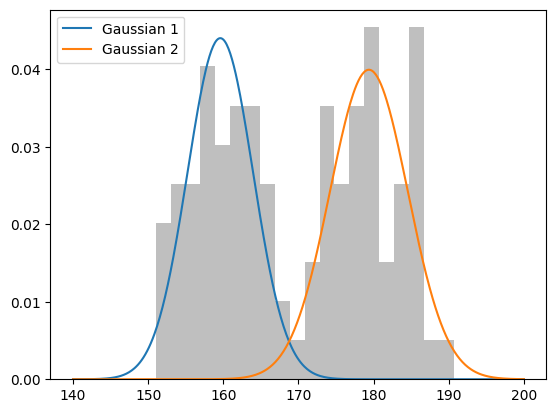

In [7]:
import numpy as np

# Synthetic data
data = np.concatenate([
    np.random.normal(160, 5, 50),
    np.random.normal(180, 5, 50)
])

# Initialize parameters
mu = [155, 185]
sigma = [5, 5]
pi = [0.5, 0.5]

def gaussian(x, mu, sigma):
    return (1 / (np.sqrt(2 * np.pi) * sigma)) * np.exp(-(x - mu)**2 / (2 * sigma**2))

# EM algorithm
max_iters = 100
tol = 1e-4  # convergence tolerance for parameter changes

for iteration in range(max_iters):
    # Store old parameters
    mu_old = mu.copy()
    sigma_old = sigma.copy()
    pi_old = pi.copy()
    
    # E-step
    responsibilities = np.array([
        pi[k] * gaussian(data, mu[k], sigma[k])
        for k in range(2)
    ])
    responsibilities /= responsibilities.sum(axis=0)  # normalize
    
    # M-step
    for k in range(2):
        Nk = responsibilities[k].sum()
        mu[k] = (responsibilities[k] * data).sum() / Nk
        sigma[k] = np.sqrt(((data - mu[k])**2 * responsibilities[k]).sum() / Nk)
        pi[k] = Nk / len(data)
    
    # Check convergence-stop if little change
    mu_change = max(abs(mu[k] - mu_old[k]) for k in range(2))
    sigma_change = max(abs(sigma[k] - sigma_old[k]) for k in range(2))
    pi_change = max(abs(pi[k] - pi_old[k]) for k in range(2))
    
    if mu_change < tol and sigma_change < tol and pi_change < tol:
        print(f"Converged at iteration {iteration + 1}")
        break

# Print final parameters
print("Final mu:", mu)
print("Final sigma:", sigma)
print("Final pi:", pi)

import matplotlib.pyplot as plt

x = np.linspace(140, 200, 500)
plt.hist(data, bins=20, density=True, alpha=0.5, color='gray')

# Plot fitted Gaussians
for k in range(2):
    plt.plot(x, pi[k] * (1/(np.sqrt(2*np.pi)*sigma[k])) * np.exp(-(x-mu[k])**2 / (2*sigma[k]**2)), label=f'Gaussian {k+1}')
plt.legend()
plt.show()


# 2c. Hidden Markov Model — weather inference

I used a Hidden Markov Model (HMM) to infer hidden weather states (Rainy or Sunny) from whether people carry an umbrella or not ($0 =$ Umbrella, $1 =$ No Umbrella).

However, because the dataset is small and the Baum–Welch algorithm maximizes likelihood without regularization, this model overfitted the observations.

**Notes for self:**

**What are the components of the model?**

Transition Matrix ($A$):  
The Markov chain for the hidden states. Each entry

$$
A[i,j] = P(X_{t+1} = j \mid X_t = i)
$$

represents the probability of transitioning from state $i$ to state $j$.

Emission Matrix ($B$):  
The stochastic link between hidden states and observations:

$$
B[i,k] = P(O_t = k \mid X_t = i)
$$

Even if the hidden state is Rainy, someone may or may not carry an umbrella. Unlike $A$, which governs hidden state transitions, $B$ governs the mapping from hidden states to observable data.

Initial State Distribution ($\pi$):
Gives the probability of the system starting in each hidden state:

$$
\pi_i = P(X_1 = i)
$$




**What are Forward / Alpha Probabilities ($\alpha_t(i)$)?**

The alpha probabilities represent the probability of being in hidden state $i$ at time $t$ and observing the sequence up to that point:

$$
\alpha_1(i) = \pi_i B[i, O_1]
$$

$$
\alpha_t(i) = \left( \sum_j \alpha_{t-1}(j) A[j,i] \right) B[i, O_t]
$$

$\alpha$ is computed recursively; we do not know it in advance.  
The forward algorithm allows us to compute the sequence likelihood efficiently:

$$
P(O_1, \dots, O_T) = \sum_i \alpha_T(i)
$$

Without this recursion, we would have to list all possible sequences of hidden states, which grows exponentially with sequence length (for $T = 10$ and 2 states, $2^{10} = 1024$ sequences).




**What is the Baum-Welch Algorithm (Expectation-Maximization)?**

Initialization: 
Start with random $A$, $B$, and $\pi$.

E-step:
Compute expected probabilities using forward ($\alpha$) and backward ($\beta$) probabilities:

$$
\gamma_t(i) = P(X_t = i \mid O, \text{current model})
$$

$$
\xi_t(i,j) = P(X_t = i, X_{t+1} = j \mid O, \text{current model})
$$

M-step:  
Update parameters based on expected counts:

$$
\pi_i = \gamma_1(i)
$$

$$
A[i,j] = \frac{\sum_{t=1}^{T-1} \xi_t(i,j)}{\sum_{t=1}^{T-1} \gamma_t(i)}
$$

$$
B[i,k] = \frac{\sum_{t : O_t = k} \gamma_t(i)}{\sum_{t=1}^{T} \gamma_t(i)}
$$

Repeat the E-step and M-step until convergence (the sequence likelihood stabilizes, ideally at a high value).


In [1]:
import numpy as np

# Observed sequences (0=Umbrella, 1=No Umbrella)
# Multiple sequences to improve learning
sequences = [
    [0,0,1,0,1,0],
    [0,1,1,0,0,1],
    [0,0,0,1,0,1],
]

num_states = 2
num_obs = 2

# Random initialization
np.random.seed(0)
A = np.random.rand(num_states, num_states)
A /= A.sum(axis=1, keepdims=True)

B = np.random.rand(num_states, num_obs)
B /= B.sum(axis=1, keepdims=True)

pi = np.random.rand(num_states)
pi /= pi.sum()

# Baum-Welch helper functions
def forward(O, A, B, pi):
    T = len(O)
    alpha = np.zeros((T, num_states))
    alpha[0] = pi * B[:, O[0]]
    for t in range(1, T):
        alpha[t] = (alpha[t-1] @ A) * B[:, O[t]]
    return alpha

def backward(O, A, B):
    T = len(O)
    beta = np.zeros((T, num_states))
    beta[-1] = 1
    for t in reversed(range(T-1)):
        beta[t] = A @ (B[:, O[t+1]] * beta[t+1])
    return beta

# Baum-Welch iterations
for iteration in range(20):
    A_num = np.zeros_like(A)
    A_den = np.zeros(num_states)
    B_num = np.zeros_like(B)
    B_den = np.zeros(num_states)
    pi_new = np.zeros_like(pi)
    
    for O in sequences:
        T = len(O)
        alpha = forward(O, A, B, pi)
        beta = backward(O, A, B)
        likelihood = alpha[-1].sum()
        
        gamma = (alpha * beta) / likelihood
        xi = np.zeros((T-1, num_states, num_states))
        for t in range(T-1):
            xi[t] = (np.outer(alpha[t], beta[t+1] * B[:, O[t+1]]) * A) / likelihood
        
        pi_new += gamma[0]
        A_num += xi.sum(axis=0)
        A_den += gamma[:-1].sum(axis=0)
        
        for k in range(num_obs):
            mask = [t for t in range(T) if O[t]==k]
            if mask:
                B_num[:,k] += gamma[mask].sum(axis=0)
        B_den += gamma.sum(axis=0)
    
    # Update parameters
    pi = pi_new / pi_new.sum()
    A = A_num / A_den[:,None]
    B = B_num / B_den[:,None]

print("Learned transition matrix A:")
print(A)
print("Learned emission matrix B:")
print(B)
print("Learned initial probabilities pi:")
print(pi)

# Verify accuracy: compute likelihood of sequences
total_likelihood = 1
for O in sequences:
    alpha = forward(O, A, B, pi)
    total_likelihood *= alpha[-1].sum()
print("Total likelihood of observed sequences:", total_likelihood)


Learned transition matrix A:
[[0.37432754 0.62567246]
 [0.78632008 0.21367992]]
Learned emission matrix B:
[[9.99977167e-01 2.28328440e-05]
 [3.23085899e-02 9.67691410e-01]]
Learned initial probabilities pi:
[1.00000000e+00 4.84886677e-13]
Total likelihood of observed sequences: 9.276426078874518e-05


# 3a. Q-learning — grid world navigation

I used tabular Q-learning with epsilon-greedy exploration to train an agent to navigate a number-line on the integers, starting on $0$ and ending at $4$. The agent can move left ($-1$) or right ($+1$) at each step, and receives a reward of $1$ for reaching the goal and $-0.01$ for all other steps.


**Notes for self:**

**What are the components of the model?**

States ($S$):
$$S = \{0, 1, 2, 3, 4\}$$

Actions ($A$):
$$A = \{-1, +1\}$$

Transition function ($P(s_{t+1} \mid s_t, a_t)$):
$$s_{t+1} = \min(4, \max(0, s_t + a_t))$$

Reward function ($R(s_t,a_t)$):
$$R(s_t, a_t) = \begin{cases} 
1 & \text{if } s_{t+1} = 4 \\
-0.01 & \text{otherwise}
\end{cases}$$

Discount factor ($\gamma$):
$$\gamma = 0.9$$

Learning rate ($\alpha$):
$$\alpha = 0.1$$

Exploration rate ($\epsilon$):** Probability of selecting a random action:
$$\epsilon = 0.1$$

**What is the Q-value table ($Q(s,a)$)?**

$Q(s,a)$ stores the agent's estimate of the expected discounted long-term reward for taking action $a$ in state $s$:

$$Q(s,a) \approx \mathbb{E}\left[\sum_{t=0}^{\infty} \gamma^t R_t \mid s_0 = s, a_0 = a\right]$$

**How are Q-values updated?**

The update rule is:

$$Q(s_t, a_t) \leftarrow Q(s_t, a_t) + \alpha\left(R(s_t, a_t) + \gamma \max_{a' \in A} Q(s_{t+1}, a') - Q(s_t, a_t)\right)$$

Where:

$R(s_t,a_t)$ = observed reward after taking action $a_t$ in state $s_t$

$s_{t+1} = \min\Big(4, \max(0, s_t + a_t)\Big)$

$\max_{a' \in A} Q(s_{t+1}, a')$ = estimate of the best future reward from $s_{t+1}$

**How does epsilon-greedy exploration work?**

At each step $t$, the action $a_t$ is chosen according to:

$$a_t = \begin{cases}
\text{random action from } A & \text{with probability } \epsilon \\
\arg\max_{a \in A} Q(s_t, a) & \text{with probability } 1-\epsilon
\end{cases}$$

This balances exploration (trying new actions) and exploitation (choosing the currently best-known action).

Without exploration, the agent may never discover the optimal path, especially in stochastic or larger environments.

With epsilon-greedy, the agent gradually learns the optimal Q-values through repeated episodes.

**How does the agent learn?**

Initialize $$Q(s,a) = 0$$ for all $$s \in S, a \in A$$

At each step, select $a_t$ using epsilon-greedy.

Observe $s_{t+1}$ and $R(s_t,a_t)$.

Update $Q(s_t,a_t)$ using the update equation above.

Repeat for many episodes; the Q-values converge toward the expected discounted reward.

In [1]:
import numpy as np

# Grid-world setup
num_states = 5
actions = [-1, 1]  # left, right
num_actions = len(actions)

# Q-table
Q = np.zeros((num_states, num_actions))

# Hyperparameters
alpha = 0.1        # learning rate
gamma = 0.9        # discount factor
epsilon = 0.1      # probability of exploring
num_episodes = 500

# Track episode lengths to see learning progress
episode_lengths = []

for episode in range(num_episodes):
    state = 0
    steps = 0

    while state != 4:  # until goal
        # Epsilon-greedy action selection
        if np.random.rand() < epsilon:
            action = np.random.choice(actions)  # explore
        else:
            action_idx = np.argmax(Q[state])    # exploit best
            action = actions[action_idx]

        action_idx = 0 if action == -1 else 1
        next_state = min(num_states-1, max(0, state + action))
        reward = 1 if next_state == 4 else -0.01

        # Q-learning update
        Q[state, action_idx] += alpha * (
            reward + gamma * Q[next_state].max() - Q[state, action_idx]
        )

        state = next_state
        steps += 1

    episode_lengths.append(steps)

    # Print Q-table every 100 episodes
    if (episode+1) % 100 == 0:
        print(f"Episode {episode+1} Q-table:")
        print(Q)
        print(f"Episode length: {steps}\n")

# Final Q-table and summary
print("Final Q-table:")
print(Q)
print(f"Average episode length: {np.mean(episode_lengths):.2f}")


Episode 100 Q-table:
[[0.18306832 0.69776224]
 [0.29139507 0.78968097]
 [0.1280147  0.88974349]
 [0.16665092 0.99997344]
 [0.         0.        ]]
Episode length: 4

Episode 200 Q-table:
[[0.33383804 0.70189939]
 [0.40460548 0.79099993]
 [0.42737012 0.88999999]
 [0.49236621 1.        ]
 [0.         0.        ]]
Episode length: 6

Episode 300 Q-table:
[[0.49779055 0.7019    ]
 [0.49351194 0.791     ]
 [0.52178094 0.89      ]
 [0.67530315 1.        ]
 [0.         0.        ]]
Episode length: 4

Episode 400 Q-table:
[[0.54040645 0.7019    ]
 [0.52825361 0.791     ]
 [0.61574961 0.89      ]
 [0.706657   1.        ]
 [0.         0.        ]]
Episode length: 4

Episode 500 Q-table:
[[0.55585413 0.7019    ]
 [0.57204344 0.791     ]
 [0.66852358 0.89      ]
 [0.74617667 1.        ]
 [0.         0.        ]]
Episode length: 4

Final Q-table:
[[0.55585413 0.7019    ]
 [0.57204344 0.791     ]
 [0.66852358 0.89      ]
 [0.74617667 1.        ]
 [0.         0.        ]]
Average episode length: 4.43


# 3b. Policy iteration — stochastic portfolio optimization

I used policy iteration on a stochastic portfolio optimization problem to find an optimal investment strategy. The portfolio can be in one of five states (portfolio values from low to high), and at each state, the agent chooses between two actions: aggressive investment (higher expected return and variance) or conservative investment (lower return, lower variance). The model improves its policy to maximize expected discounted portfolio gains over time.

**Notes for self:**

**What are the components of the model?**

States ($S$): Discretized portfolio values representing current wealth.

Actions ($A$): Investment strategies in each state ($0 =$ aggressive, $1 =$ conservative).

Transition probabilities ($P[s'|s,a]$): Probability of moving from state $s$ to $s'$ given action $a$. In this model, transitions are stochastic, estimated via Monte Carlo simulation of random returns.

Rewards ($R(s)$): Immediate gain in portfolio value when in state $s$. Computed as $R = \text{next portfolio value} - \text{current value}$.

Discount factor ($\gamma$): Determines how much future rewards are worth relative to immediate rewards, $0 < \gamma < 1$.

**What is a policy ($\pi$)?**

A policy maps each state to an action: $\pi(s) = a$.

It is initially random.

Policy iteration determines the policy by:
1. Evaluating the current policy's value function $V^\pi(s)$.
2. Updating $\pi(s)$ to choose the action maximizing expected future reward.
3. Repeating until the policy stabilizes (optimal policy $\pi^*$).

**What is the value function and the Bellman expectation equation?**

Value function ($V^\pi(s)$): Expected total discounted reward starting from state $s$ following policy $\pi$:

$$V^\pi(s) = \mathbb{E}\left[\sum_{t=0}^{\infty} \gamma^t R(s_t) \mid \pi\right]$$

Bellman expectation equation: Recursively expresses $V^\pi$ in terms of immediate reward and expected future value:

$$V^\pi(s) = R(s) + \gamma \sum_{s'} P(s' \mid s, \pi(s)) V^\pi(s')$$

Components:
- $R(s)$: immediate reward
- $\gamma$: discount factor
- $P(s'|s,\pi(s))$: probability of transitioning to $s'$ under action $\pi(s)$

Fixed point: The value function $V^\pi$ that satisfies this equation. Iteratively applying the Bellman update converges to this $V^\pi$.

**How does the model "train"?**

1. Policy evaluation: Compute expected future rewards under current policy (Monte Carlo approximation of $V^\pi$).
2. Policy improvement: Update the policy to maximize $V^\pi$ in each state.
3. Repeat until the policy stops changing.

In [3]:
import numpy as np
import matplotlib.pyplot as plt

# PARAMETERS
np.random.seed(0)

num_states = 5  # portfolio bins: 0=very low, 4=very high
num_actions = 2  # 0=aggressive, 1=conservative
gamma = 0.9  # discount factor

# Discretized portfolio values for states
portfolio_bins = np.linspace(1000, 5000, num_states)

# Random return simulation per action
def simulate_return(action):
    """
    Simulates the portfolio return given an action.
    action 0 = aggressive (higher mean, higher variance)
    action 1 = conservative (lower mean, lower variance)
    """
    if action == 0:
        return np.random.normal(1.05, 0.10)  # aggressive: +5% avg, 10% std
    else:
        return np.random.normal(1.02, 0.03)  # conservative: +2% avg, 3% std

# INITIAL POLICY AND VALUE FUNCTION
policy = np.random.choice(num_actions, size=num_states)  # random start
V = np.zeros(num_states)

print("Initial policy:", policy)

# POLICY ITERATION
num_iterations = 20

for iteration in range(num_iterations):
    # --- Policy Evaluation ---
    for eval_iter in range(50):  # inner loop to converge V
        V_new = np.zeros(num_states)
        for s, val in enumerate(portfolio_bins):
            a = policy[s]
            expected_rewards = []
            # Monte Carlo estimate of expected next-state value
            for _ in range(100):
                next_val = val * simulate_return(a)
                # map next_val to nearest state bin
                next_state = np.argmin(np.abs(portfolio_bins - next_val))
                reward = next_val - val  # reward = gain in portfolio
                expected_rewards.append(reward + gamma * V[next_state])
            V_new[s] = np.mean(expected_rewards)
        V = V_new

    # Policy Improvement
    policy_stable = True
    for s, val in enumerate(portfolio_bins):
        action_values = []
        for a in range(num_actions):
            sim_rewards = []
            for _ in range(100):
                next_val = val * simulate_return(a)
                next_state = np.argmin(np.abs(portfolio_bins - next_val))
                reward = next_val - val
                sim_rewards.append(reward + gamma * V[next_state])
            action_values.append(np.mean(sim_rewards))
        best_action = np.argmax(action_values)
        if best_action != policy[s]:
            policy_stable = False
        policy[s] = best_action

    print(f"Iteration {iteration+1}: Policy = {policy}, V = {np.round(V,2)}")
    if policy_stable:
        print("Policy has converged.")
        break

# SIMULATE AN EPISODE
state_value = 3000.0  # start from initial portfolio
trajectory_values = [state_value]
total_discounted_reward = 0.0

for t in range(10):
    action = policy[np.argmin(np.abs(portfolio_bins - state_value))]  # choose action based on nearest bin
    # simulate stochastic return
    if action == 0:  # aggressive
        return_multiplier = np.random.normal(1.05, 0.10)  # mean 5%, std 10%
    else:  # conservative
        return_multiplier = np.random.normal(1.02, 0.03)  # mean 2%, std 3%
    next_value = state_value * return_multiplier
    reward = next_value - state_value
    total_discounted_reward += (gamma**t) * reward
    state_value = next_value
    trajectory_values.append(state_value)

print("Simulated portfolio trajectory:", np.round(trajectory_values, 2))
print("Total discounted gain:", round(total_discounted_reward, 2))

Initial policy: [0 1 1 0 1]
Iteration 1: Policy = [0 0 0 0 0], V = [ 525.78  379.75  614.26 1171.37  981.88]
Iteration 2: Policy = [0 0 0 0 0], V = [ 519.01 1043.37 1781.8  2043.16 2231.9 ]
Policy has converged.
Simulated portfolio trajectory: [3000.   3409.56 3428.05 3616.06 3659.83 3175.47 3703.15 3623.1  4043.19
 3925.32 4463.33]
Total discounted gain: 920.28
